# Computer Vision with Custom Datasets

## 0. Setting up

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

The dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per classes.

This dataset starts with 3 classes of food and only 10% of the images.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak, and sushi data...


In [4]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Data preparation and data exploration

In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [7]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1. Visualizing image

1. Get all of the image paths
2. Pick a random image path using `random.choice()`
3. Get the image class name `pathlib.Path.parent.stem`
4. Open the image with PIL
5. Show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/1503858.jpg
Random image class: pizza
Image height: 384
Image width: 512


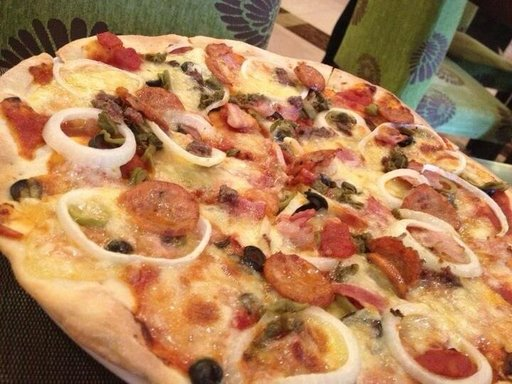

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the name class is the name of the directory)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

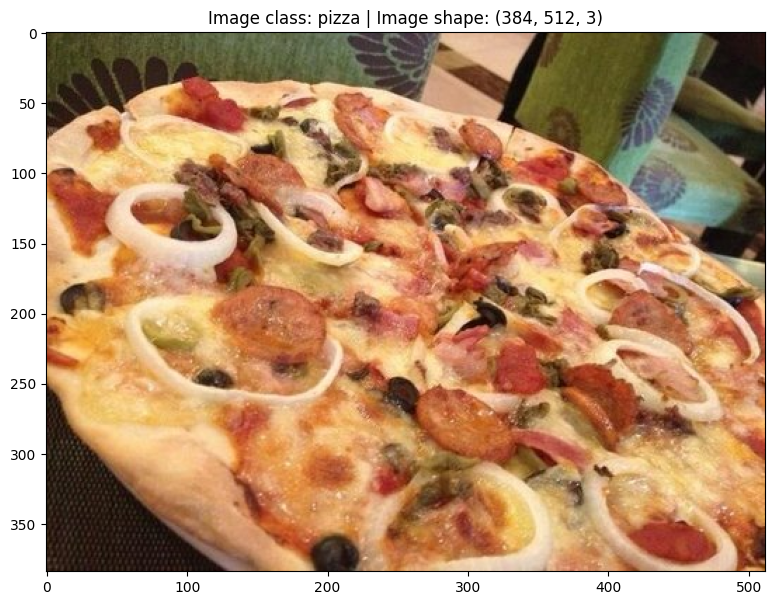

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}");

## 3. Transforming data
1. Turn target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subquently a `torch.utils.data.DataLoader`.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1. Transforming data with `torchvision.transforms`

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

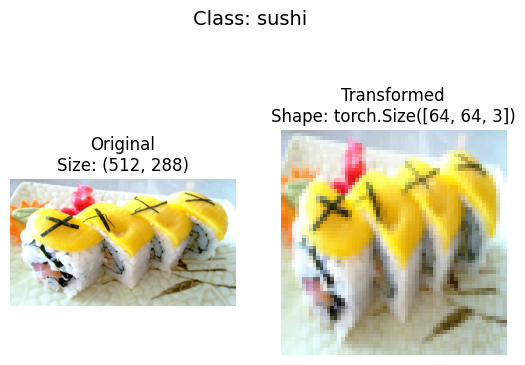

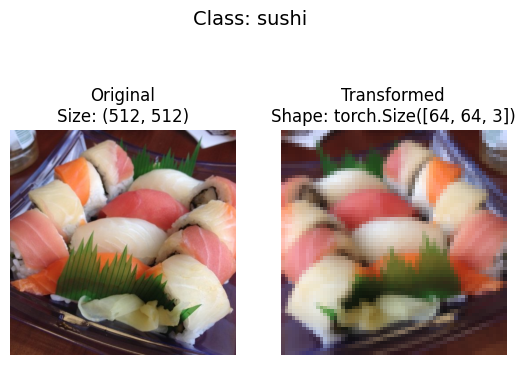

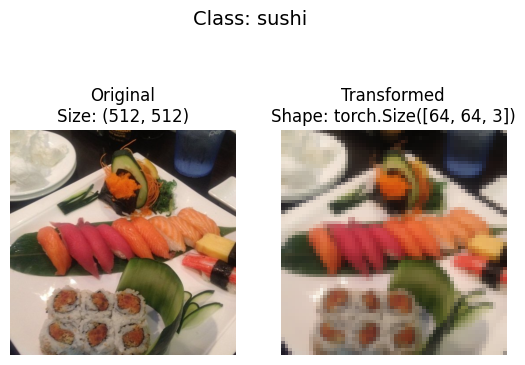

In [14]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading image data using `ImageFolder`
Load image classification data using `torchvision.datasets.ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the length of dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.targets[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Image datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64])
Image permute: torch.Size([64, 64, 3])


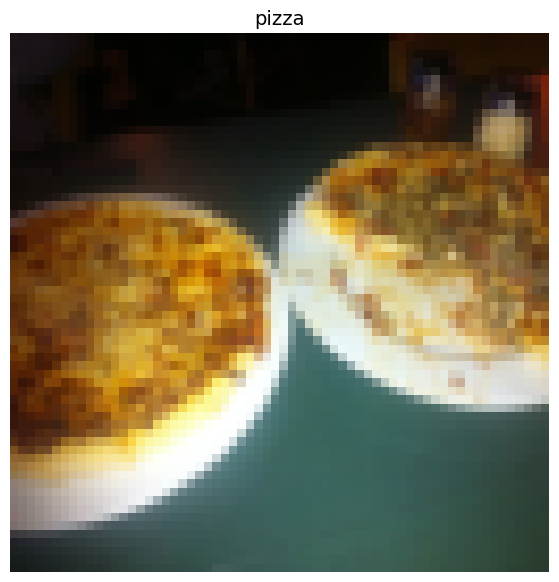

In [22]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape}")
print(f"Image permute: {img_permute.shape}")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1. Turn loaded images into `DataLoader`
A `DataLoader` is going to help turn the Dataset's into iterables and we can cutomize the `batch_size` so our model can see `batch_size` images at a time.

In [23]:
# Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=True)

In [24]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [25]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> (batch_size, color_channels, height, width)")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> (batch_size, color_channels, height, width)
Label shape: torch.Size([32])


## 5. Option 2: Loading image data with a custom `Dataset`
1. Be able to load images from file
2. Be able to get class names from the Dataset
3. Be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Prone to errors or performance issues

In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1. Creating a helper function to get class names

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # Create a dictionary of index labels (computers prefer numbers rather than strings)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [29]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2. Create a custom `Dataset` to replicate `ImageFolder`

In [30]:
# Write a custom dataset class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, target_dir: str, transform=None):
    # Get all of the image paths
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    # Setup transform
    self.tranform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(target_dir)

  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [31]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                     transform=test_transforms)

In [33]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ab21f23e6b0>,
 <__main__.ImageFolderCustom at 0x7ab21f23cee0>)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
len(test_data), len(test_data)

(75, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3. Create a function to display random images

In [38]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger that 10, setting to 10 and removing shape display.")

  # Set the seed
  if seed:
    random.seed(seed)

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
      plt.title(title)

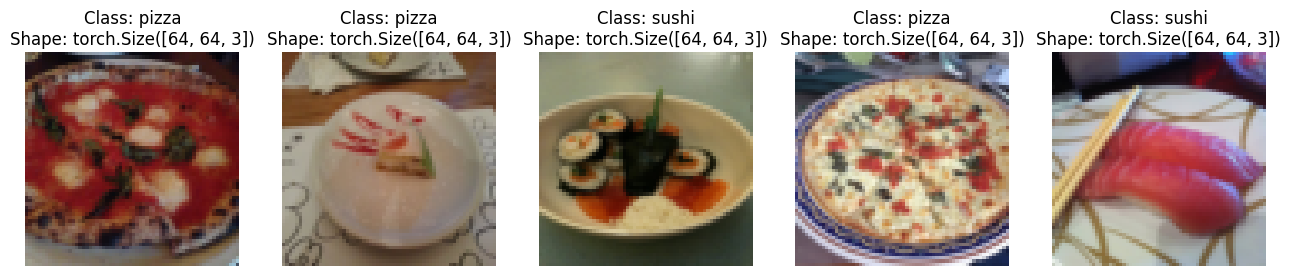

In [39]:
# Display random images from the ImageFolder created dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

## 6. Data augmentation

In [40]:
# Use trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=5),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()])

In [41]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3177743.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg')]

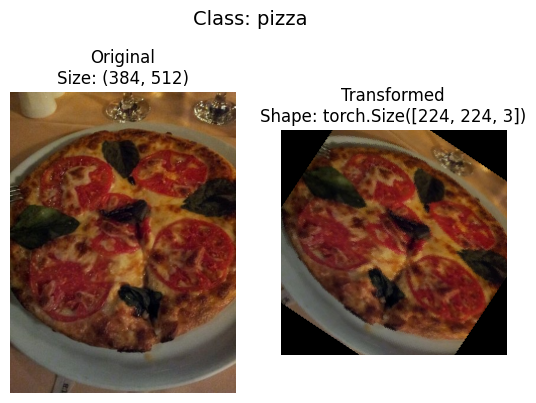

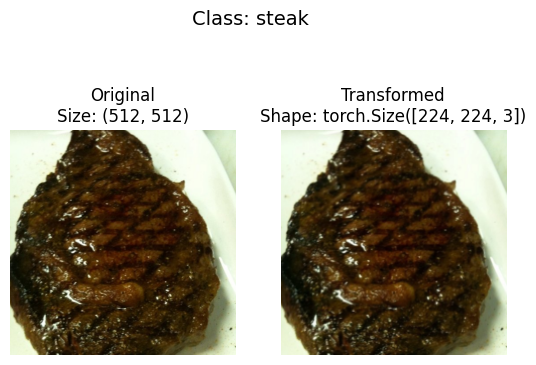

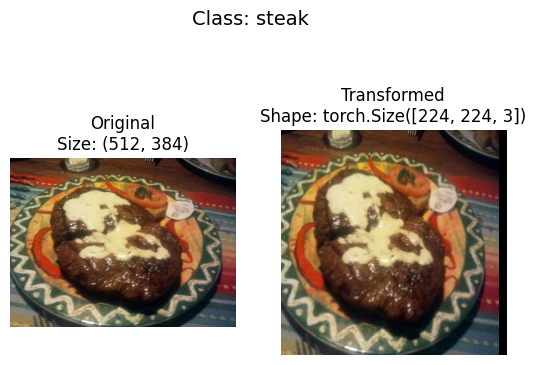

In [42]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1. Creating transforms and loading data for Model 0

In [43]:
# Create simple transforms
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()])

In [44]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Turn the datasets into DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2. Create TinyVGG model class

In [45]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

### 7.3. Finding the hidden units for in features in classifier layer

In [46]:
!pip install torchinfo

In [47]:
from torchinfo import summary

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
summary(model_0, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [48]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 7.4. Create train and test loops functions

In [49]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device="cpu"):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accruacy values
  train_loss = 0
  train_acc = 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class==y).sum().item())/len(y_pred_class)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [50]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device="cpu"):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss = 0
  test_acc = 0

  # Turn on inference mode
  with torch.inference_mode():
    # loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += ((test_pred_labels==y).sum().item())/len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

### 7.5. Creating a `train()` function to combine `train_step()` and `test_step()`

In [51]:
from tqdm.auto import tqdm

# Create a train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device="cpu"):

  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # Print out
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {100*test_acc:.2f}%")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

### 7.6. Train and evaluate Model 0

In [52]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epoch
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1078 | Train acc: 25.78% | Test loss: 1.1362 | Test acc: 26.04%
Epoch: 1 | Train loss: 1.0846 | Train acc: 42.58% | Test loss: 1.1622 | Test acc: 19.79%
Epoch: 2 | Train loss: 1.1153 | Train acc: 29.30% | Test loss: 1.1694 | Test acc: 19.79%
Epoch: 3 | Train loss: 1.0992 | Train acc: 28.91% | Test loss: 1.1338 | Test acc: 19.79%
Epoch: 4 | Train loss: 1.0989 | Train acc: 29.30% | Test loss: 1.1436 | Test acc: 19.79%
Epoch: 5 | Train loss: 1.0963 | Train acc: 30.86% | Test loss: 1.1483 | Test acc: 26.04%
Epoch: 6 | Train loss: 1.1185 | Train acc: 32.81% | Test loss: 1.1419 | Test acc: 31.25%
Epoch: 7 | Train loss: 1.1008 | Train acc: 36.72% | Test loss: 1.1036 | Test acc: 21.88%
Epoch: 8 | Train loss: 1.0875 | Train acc: 50.00% | Test loss: 1.0642 | Test acc: 54.17%
Epoch: 9 | Train loss: 1.0644 | Train acc: 40.23% | Test loss: 1.0137 | Test acc: 54.17%
Epoch: 10 | Train loss: 1.0405 | Train acc: 42.58% | Test loss: 0.9757 | Test acc: 60.42%
Epoch: 11 | Train lo

### 7.7. Plot the loass curves of Model 0

In [53]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [54]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(16, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

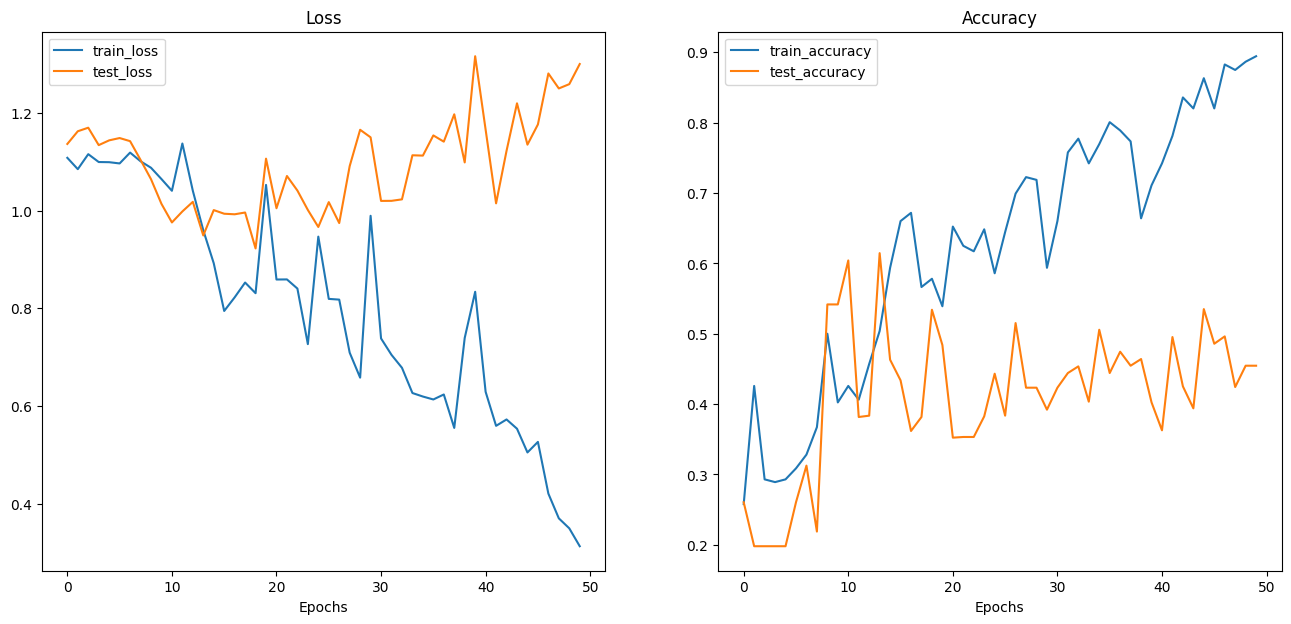

In [55]:
plot_loss_curves(model_0_results)

## 8. Model 1: TinyVGG with data augmentation

### 8.1. Create transform with data augmentation

In [56]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([transforms.Resize(size=(64, 64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()])
test_transform_simple = transforms.Compose([transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()])

### 8.2. Create train and test `Dataset'`s and `DataLoader`'s with data augmentation

In [57]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_datal_simple = datasets.ImageFolder(root=train_dir,
                                         transform=test_transform_simple)

In [58]:
# Turn Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 8.3. Construct and train Model 1

In [59]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

# Setup loss and optimzier function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer
start_timer = timer()

# Setup epochs
NUM_EPOCHS = 50

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print how long it took
end_time = timer()
print(f"Total training time for model 1: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1070 | Train acc: 25.78% | Test loss: 1.1383 | Test acc: 26.04%
Epoch: 1 | Train loss: 1.0827 | Train acc: 42.58% | Test loss: 1.1681 | Test acc: 19.79%
Epoch: 2 | Train loss: 1.1221 | Train acc: 29.30% | Test loss: 1.1740 | Test acc: 19.79%
Epoch: 3 | Train loss: 1.0955 | Train acc: 41.41% | Test loss: 1.1427 | Test acc: 20.83%
Epoch: 4 | Train loss: 1.0948 | Train acc: 30.47% | Test loss: 1.1418 | Test acc: 21.88%
Epoch: 5 | Train loss: 1.0959 | Train acc: 33.98% | Test loss: 1.1454 | Test acc: 26.04%
Epoch: 6 | Train loss: 1.1122 | Train acc: 39.06% | Test loss: 1.1332 | Test acc: 23.96%
Epoch: 7 | Train loss: 1.0932 | Train acc: 30.08% | Test loss: 1.0993 | Test acc: 23.96%
Epoch: 8 | Train loss: 1.0837 | Train acc: 51.95% | Test loss: 1.0781 | Test acc: 48.30%
Epoch: 9 | Train loss: 1.0697 | Train acc: 43.36% | Test loss: 1.0530 | Test acc: 58.33%
Epoch: 10 | Train loss: 1.0540 | Train acc: 44.14% | Test loss: 1.0193 | Test acc: 58.33%
Epoch: 11 | Train lo

### 8.4. Plot the loss curves of Model 1

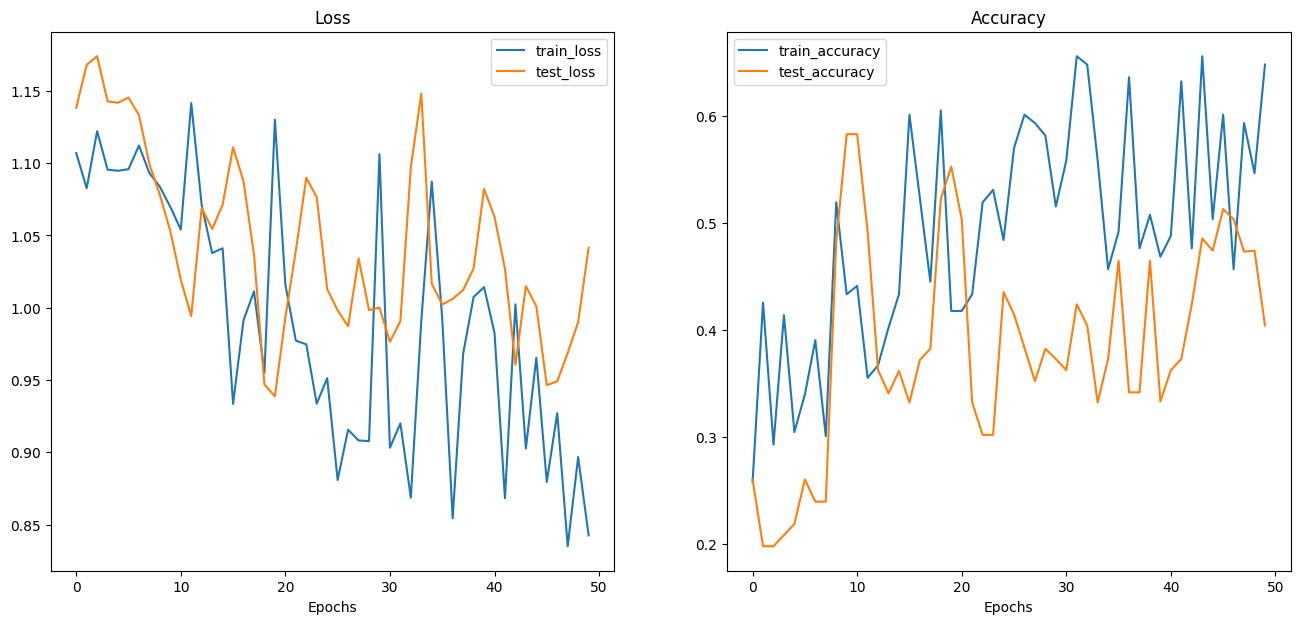

In [60]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [61]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

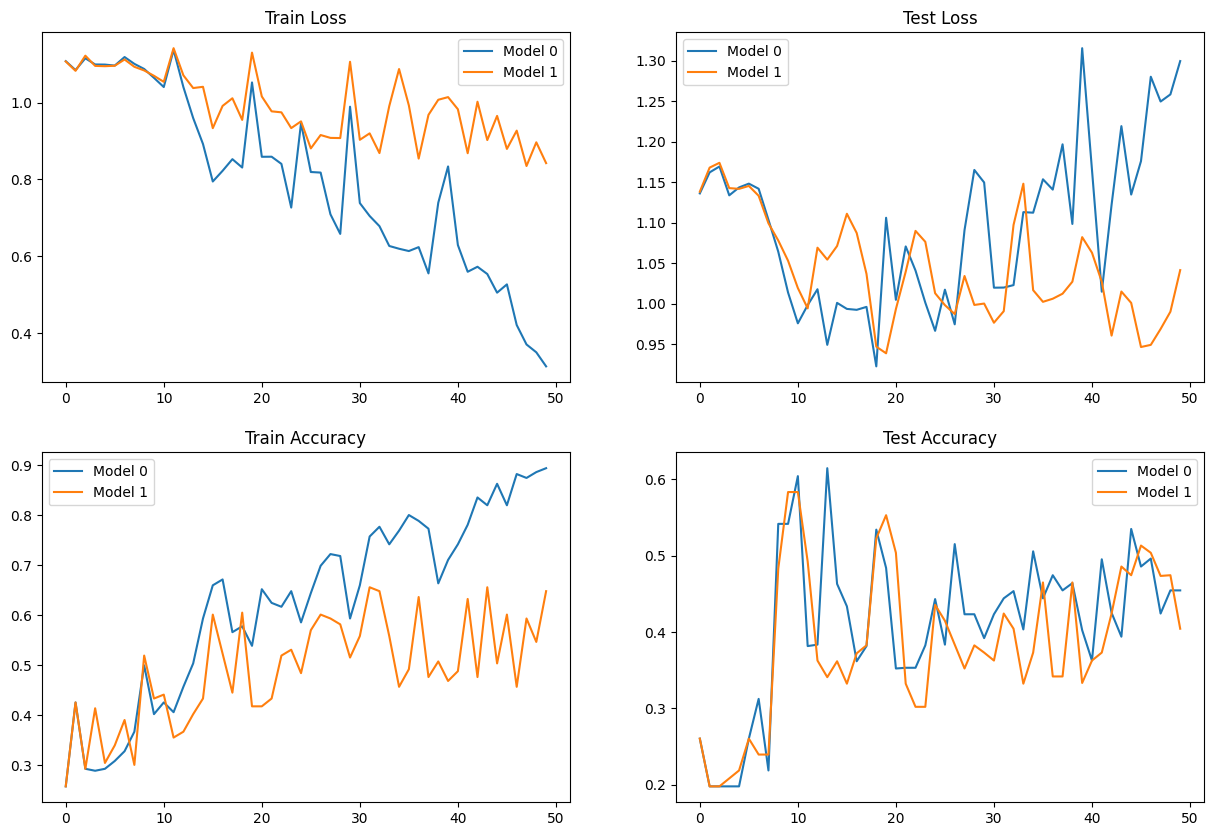

In [62]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.legend()

# Plot train accuarcy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.legend()

# Plot test accuarcy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.legend();

## 11. Making a prediction on a custom image

In [74]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza-test.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/almosenja/PyTorch/main/data/pizza-test.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

### 11.1. Loading in a custom image with PyTorch

In [81]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n{custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[218, 218, 217,  ..., 241, 241, 241],
         [214, 214, 213,  ..., 229, 229, 230],
         [215, 215, 214,  ..., 204, 204, 205],
         ...,
         [148, 161, 165,  ..., 175, 181, 186],
         [154, 159, 161,  ..., 179, 185, 191],
         [163, 158, 157,  ..., 179, 186, 193]],

        [[170, 170, 171,  ..., 211, 211, 211],
         [165, 165, 167,  ..., 200, 200, 199],
         [165, 165, 167,  ..., 176, 176, 175],
         ...,
         [ 81,  94,  98,  ..., 118, 124, 129],
         [ 87,  92,  94,  ..., 122, 128, 134],
         [ 93,  89,  87,  ..., 125, 132, 138]],

        [[134, 134, 135,  ..., 203, 201, 201],
         [133, 133, 134,  ..., 194, 192, 194],
         [140, 140, 141,  ..., 175, 173, 175],
         ...,
         [ 55,  68,  72,  ...,  99, 107, 112],
         [ 61,  65,  68,  ..., 102, 108, 115],
         [ 67,  60,  61,  ..., 101, 108, 117]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 183, 275])
Custom image datatyp

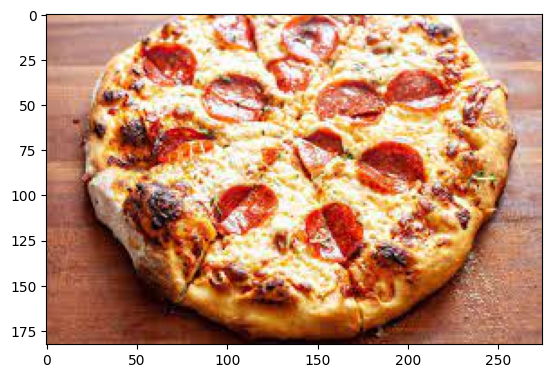

In [80]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

### 11.2. Making a prediction on a custom image with a trained PyTorch model

In [84]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.8549, 0.8549, 0.8510,  ..., 0.9451, 0.9451, 0.9451],
         [0.8392, 0.8392, 0.8353,  ..., 0.8980, 0.8980, 0.9020],
         [0.8431, 0.8431, 0.8392,  ..., 0.8000, 0.8000, 0.8039],
         ...,
         [0.5804, 0.6314, 0.6471,  ..., 0.6863, 0.7098, 0.7294],
         [0.6039, 0.6235, 0.6314,  ..., 0.7020, 0.7255, 0.7490],
         [0.6392, 0.6196, 0.6157,  ..., 0.7020, 0.7294, 0.7569]],

        [[0.6667, 0.6667, 0.6706,  ..., 0.8275, 0.8275, 0.8275],
         [0.6471, 0.6471, 0.6549,  ..., 0.7843, 0.7843, 0.7804],
         [0.6471, 0.6471, 0.6549,  ..., 0.6902, 0.6902, 0.6863],
         ...,
         [0.3176, 0.3686, 0.3843,  ..., 0.4627, 0.4863, 0.5059],
         [0.3412, 0.3608, 0.3686,  ..., 0.4784, 0.5020, 0.5255],
         [0.3647, 0.3490, 0.3412,  ..., 0.4902, 0.5176, 0.5412]],

        [[0.5255, 0.5255, 0.5294,  ..., 0.7961, 0.7882, 0.7882],
         [0.5216, 0.5216, 0.5255,  ..., 0.7608, 0.7529, 0.7608],
         [0.5490, 0.5490, 0.5529,  ..., 0.6863, 0.6784, 0.

In [86]:
# Create transform pipeline to resize the image
from torchvision import transforms

custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 183, 275])
Transformed shape: torch.Size([3, 64, 64])


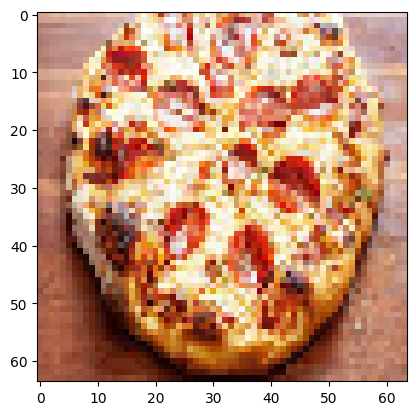

In [88]:
plt.imshow(custom_image_transformed.permute(1, 2, 0));

In [90]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [89]:
# Make prediction
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [91]:
custom_image_pred

tensor([[ 0.7998, -1.9992, -0.0616]], device='cuda:0')

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [94]:
# Convert logits -> prediction probabibilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.6741, 0.0410, 0.2849]], device='cuda:0')

In [97]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu() # Convert to cpu to prevent error later on
custom_image_pred_label

tensor([0])

### 11.3. Putting custom image prediction together: building a function

In [99]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Devide the image pixel values by 255 to get them betwee 0, 1
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image
    target_image_pred = model(target_image.to(device))

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"

  plt.title(title)
  plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


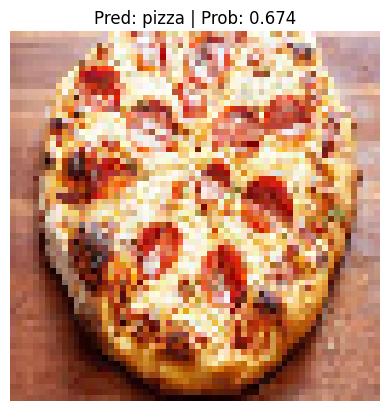

In [100]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)